# Compare metadata dumps

In [1]:
from dataclasses import asdict
from datetime import datetime
from pathlib import Path
from typing import Any

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from allisbns.dataset import BinnedArray, CodeDataset
from allisbns.errors import InvalidISBNError
from allisbns.isbn import (
    LAST_ISBN,
    MaskedISBN,
    normalize_isbn,
    validate_isbn,
)
from allisbns.merge import difference
from allisbns.plotting import BlockBinnedPlotter


%load_ext autoreload
%autoreload 2

## Load data

In [2]:
all_input_paths = sorted(Path("./").glob("aa_isbn13_codes*"))
all_input_paths

[PosixPath('aa_isbn13_codes_20251103T124740Z.benc.zst'),
 PosixPath('aa_isbn13_codes_20251118T170842Z.benc.zst')]

## Compare datasets

In [3]:
previous_path, last_path = all_input_paths
previous_path, last_path

(PosixPath('aa_isbn13_codes_20251103T124740Z.benc.zst'),
 PosixPath('aa_isbn13_codes_20251118T170842Z.benc.zst'))

In [4]:
extract_timestamp = lambda x: x.removesuffix(".benc.zst").split("_")[-1]

In [5]:
previous_timestamp = extract_timestamp(previous_path.name)
last_timestamp = extract_timestamp(last_path.name)
datetime.fromisoformat(last_timestamp) - datetime.fromisoformat(previous_timestamp)

datetime.timedelta(days=15, seconds=15662)

In [6]:
datasets_to_compare = [
    CodeDataset.from_file(path, "md5", fill_to_isbn=LAST_ISBN)
    for path in (previous_path, last_path)
]
datasets_to_compare

[CodeDataset(array([     6,      1,      9, ...,  91739,      1, 531099],
       shape=(14739690,)), bounds=(978000000000, 979999999999)),
 CodeDataset(array([     6,      1,      9, ...,  91739,      1, 531099],
       shape=(14737376,)), bounds=(978000000000, 979999999999))]

In [7]:
previous, last = datasets_to_compare
previous.count_filled_isbns(), last.count_filled_isbns()

(16892482, 16916212)

In [8]:
dataset_additions = difference([last, previous])
dataset_additions

CodeDataset(array([       0,  8036386,        1, ..., 31957917,        1, 11023931],
      shape=(40224,), dtype=int32), bounds=(978000000000, 979999999999))

In [9]:
dataset_deletions = difference([previous, last])
dataset_deletions

CodeDataset(array([         0, 2000000000], dtype=int32), bounds=(978000000000, 979999999999))

In [10]:
(dataset_additions.count_filled_isbns(), dataset_deletions.count_filled_isbns())

(23730, 0)

## Plot added ISBNs

In [11]:
binned_additions = dataset_additions.bin(2000)
addition_mask = np.where(binned_additions.bins > 0, True, False)
addition_mask

array([False, False, False, ..., False, False, False], shape=(1000000,))

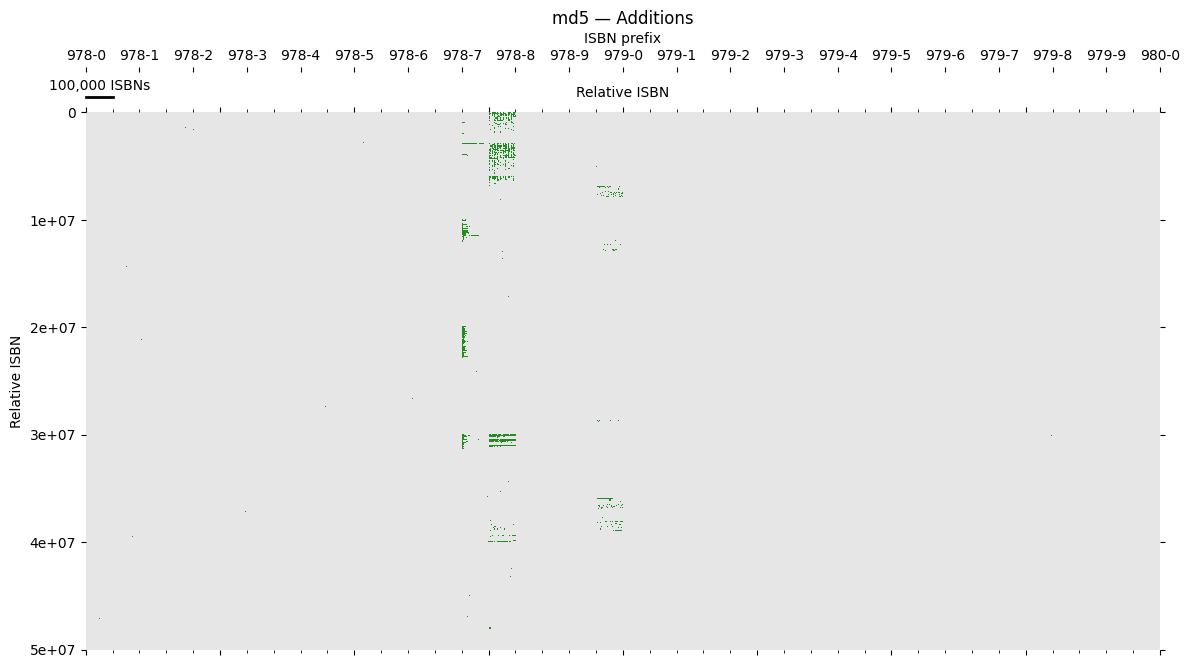

In [12]:
fig, ax = plt.subplots(figsize=(12, 12))

plotter = BlockBinnedPlotter(ax, bin_size=binned_additions.bin_size, aspect=2)

binned_addition_mask = BinnedArray(addition_mask, bin_size=binned_additions.bin_size)

plotter.plot_bins(
    binned_addition_mask,
    colormap=mpl.colors.ListedColormap(["forestgreen"]),
    show_colorbar=False,
    vmin=0,
    vmax=1,
)

ax.set_facecolor("0.9")

plt.title("md5 — Additions")

plt.tight_layout()
plt.show()

## Get added ISBNs

In [13]:
added_isbn12s = dataset_additions.get_filled_isbns()
added_isbn12s

array([978008036386, 978047150044, 978047150288, ..., 979788408648,
       979957018150, 979988976068], shape=(23730,))

## Get largest groups and registrants

In [14]:
def process_isbn(x: int) -> dict[str, Any]:
    try:
        canonical_isbn = normalize_isbn(x)
        masked_isbn = MaskedISBN.from_canonical(canonical_isbn)
        return {
            "canonical": str(canonical_isbn),
            "formatted": masked_isbn.hyphenate(),
            **asdict(masked_isbn),
        }
    except InvalidISBNError:
        return {
            "canonical": str(canonical_isbn),
        }


isbns_df = pl.DataFrame({"isbn12": added_isbn12s})

isbns_df = isbns_df.with_columns(
    columns=pl.col("isbn12").map_elements(
        process_isbn,
        skip_nulls=True,
        return_dtype=pl.Struct(
            {
                "canonical": pl.String,
                "formatted": pl.String,
                "bookland": pl.String,
                "group": pl.String,
                "registrant": pl.String,
                "publication": pl.String,
                "check_digit": pl.String,
            }
        ),
    )
).unnest("columns")
isbns_df

isbn12,canonical,formatted,bookland,group,registrant,publication,check_digit
i64,str,str,str,str,str,str,str
978008036386,"""9780080363868""","""978-0-08-036386-8""","""978""","""0""","""08""","""036386""","""8"""
978047150044,"""9780471500445""","""978-0-471-50044-5""","""978""","""0""","""471""","""50044""","""5"""
978047150288,"""9780471502883""","""978-0-471-50288-3""","""978""","""0""","""471""","""50288""","""3"""
978064451614,"""9780644516143""","""978-0-644-51614-3""","""978""","""0""","""644""","""51614""","""3"""
978079230308,"""9780792303084""","""978-0-7923-0308-4""","""978""","""0""","""7923""","""0308""","""4"""
…,…,…,…,…,…,…,…
978988999679,"""9789889996796""","""978-988-99967-9-6""","""978""","""988""","""99967""","""9""","""6"""
979780192266,"""9797801922662""",null,null,null,null,null,null
979788408648,"""9797884086480""",null,null,null,null,null,null


In [15]:
(
    isbns_df.filter(pl.col("formatted").is_null())
    .select("isbn12")
    .with_columns(
        errors=pl.col("isbn12").map_elements(
            lambda x: validate_isbn(normalize_isbn(x), return_reasons=True)[1],
            return_dtype=pl.List(pl.String),
        )
    )
)

isbn12,errors
i64,list[str]
978978703071,"[""bad_registrant""]"
978978711204,"[""bad_registrant""]"
978978751440,"[""bad_registrant""]"
979780192266,"[""bad_group""]"
979788408648,"[""bad_group""]"
979957018150,"[""bad_group""]"
979988976068,"[""bad_group""]"


In [16]:
valid_isbns_df = isbns_df.filter(pl.col("formatted").is_not_null())
valid_isbns_df

isbn12,canonical,formatted,bookland,group,registrant,publication,check_digit
i64,str,str,str,str,str,str,str
978008036386,"""9780080363868""","""978-0-08-036386-8""","""978""","""0""","""08""","""036386""","""8"""
978047150044,"""9780471500445""","""978-0-471-50044-5""","""978""","""0""","""471""","""50044""","""5"""
978047150288,"""9780471502883""","""978-0-471-50288-3""","""978""","""0""","""471""","""50288""","""3"""
978064451614,"""9780644516143""","""978-0-644-51614-3""","""978""","""0""","""644""","""51614""","""3"""
978079230308,"""9780792303084""","""978-0-7923-0308-4""","""978""","""0""","""7923""","""0308""","""4"""
…,…,…,…,…,…,…,…
978988995623,"""9789889956233""","""978-988-99562-3-3""","""978""","""988""","""99562""","""3""","""3"""
978988995664,"""9789889956646""","""978-988-99566-4-6""","""978""","""988""","""99566""","""4""","""6"""
978988995978,"""9789889959784""","""978-988-99597-8-4""","""978""","""988""","""99597""","""8""","""4"""


### Largest groups

In [17]:
grouped_by_group_df = (
    valid_isbns_df.group_by("bookland", "group")
    .agg("formatted", pl.len().alias("count"))
    .sort("count", descending=True)
)
grouped_by_group_df.head(10)

bookland,group,formatted,count
str,str,list[str],u32
"""978""","""7""","[""978-7-01-000569-0"", ""978-7-01-000570-6"", … ""978-7-980047-16-4""]",21664
"""978""","""986""","[""978-986-00-0021-4"", ""978-986-00-0063-4"", … ""978-986-93422-0-9""]",998
"""978""","""957""","[""978-957-00-0975-0"", ""978-957-00-0976-7"", … ""978-957-99760-9-1""]",816
"""978""","""988""","[""978-988-01-2212-5"", ""978-988-13228-2-1"", … ""978-988-99967-9-6""]",107
"""978""","""962""","[""978-962-07-1416-0"", ""978-962-278-273-0"", … ""978-962-967-053-5""]",76
"""978""","""1""","[""978-1-212-07793-6"", ""978-1-4131-8692-5"", … ""978-1-880132-96-8""]",20
"""978""","""90""","[""978-90-5199-243-4"", ""978-90-5199-244-1"", … ""978-90-6764-309-2""]",11
"""978""","""0""","[""978-0-08-036386-8"", ""978-0-471-50044-5"", … ""978-0-89573-971-1""]",7
"""978""","""978""","[""978-978-51261-5-0"", ""978-978-56578-9-0"", … ""978-978-986-028-9""]",5


### Largest registrants

In [18]:
grouped_by_registrant_df = (
    valid_isbns_df.group_by("bookland", "group", "registrant")
    .agg("formatted", pl.len().alias("count"))
    .sort("count", descending=True)
)
grouped_by_registrant_df.head(10)

bookland,group,registrant,formatted,count
str,str,str,list[str],u32
"""978""","""7""","""115""","[""978-7-115-05327-5"", ""978-7-115-05419-7"", … ""978-7-115-60116-2""]",1580
"""978""","""7""","""112""","[""978-7-112-00015-9"", ""978-7-112-00129-3"", … ""978-7-112-29418-3""]",744
"""978""","""7""","""03""","[""978-7-03-000093-4"", ""978-7-03-000099-6"", … ""978-7-03-103866-0""]",677
"""978""","""7""","""224""","[""978-7-224-00057-3"", ""978-7-224-00562-2"", … ""978-7-224-12650-1""]",336
"""978""","""7""","""101""","[""978-7-101-01058-9"", ""978-7-101-01304-7"", … ""978-7-101-13326-4""]",321
"""978""","""7""","""113""","[""978-7-113-00981-6"", ""978-7-113-01167-3"", … ""978-7-113-22050-1""]",312
"""978""","""7""","""5329""","[""978-7-5329-0071-8"", ""978-7-5329-0074-9"", … ""978-7-5329-2721-0""]",262
"""978""","""7""","""5303""","[""978-7-5303-0425-9"", ""978-7-5303-0444-0"", … ""978-7-5303-5063-8""]",260
"""978""","""957""","""01""","[""978-957-01-0007-5"", ""978-957-01-0047-1"", … ""978-957-01-9959-8""]",255
